In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

resultsPath = Path("../results/OpenMP_4.csv")

In [9]:
dataFrame = pd.read_csv(resultsPath)
dataFrame["matrixSize"] = dataFrame["matrixSize"].astype(int)
dataFrame["numThreads"] = dataFrame["numThreads"].astype(int)
dataFrame["timeSeconds"] = dataFrame["timeSeconds"].astype(float)
dataFrame["runIndex"] = dataFrame["runIndex"].astype(int)

print("Loaded rows:", len(dataFrame))
print("Modes:", dataFrame["mode"].unique())
print("Matrix sizes:", sorted(dataFrame["matrixSize"].unique()))
print("Thread counts:", sorted(dataFrame["numThreads"].unique()))
dataFrame.head(8)

Loaded rows: 320
Modes: ['reduction' 'no_reduction']
Matrix sizes: [500, 1000, 2000, 4000]
Thread counts: [1, 2, 4, 6, 8, 16, 32, 64]


,testType,matrixSize,numThreads,mode,timeSeconds,maxOfRowMins,runIndex,ompEnv
0,OpenMP_4,500,1,reduction,0.000192,12584.8,1,OMP_NUM_THREADS=1
1,OpenMP_4,500,1,reduction,0.000108,12099.9,2,OMP_NUM_THREADS=1
2,OpenMP_4,500,1,reduction,0.000119,14329.9,3,OMP_NUM_THREADS=1
3,OpenMP_4,500,1,reduction,0.000108,12599.1,4,OMP_NUM_THREADS=1
4,OpenMP_4,500,1,reduction,0.000108,13992.6,5,OMP_NUM_THREADS=1
5,OpenMP_4,500,2,reduction,0.000150,15107.2,1,OMP_NUM_THREADS=2
6,OpenMP_4,500,2,reduction,0.000161,14907.2,2,OMP_NUM_THREADS=2
7,OpenMP_4,500,2,reduction,0.000153,16986.3,3,OMP_NUM_THREADS=2


In [10]:
groupedFrame = dataFrame.groupby(["mode","matrixSize","numThreads"], as_index=False).agg(
    median=("timeSeconds","median"),
    mean=("timeSeconds","mean"),
    std=("timeSeconds","std"),
    count=("timeSeconds","count")
)
groupedFrame["std"] = groupedFrame["std"].fillna(0.0)
groupedFrame = groupedFrame.sort_values(["mode","matrixSize","numThreads"]).reset_index(drop=True)
groupedFrame.head(12)

,mode,matrixSize,numThreads,median,mean,std,count
0,no_reduction,500,1,0.000136,0.000129,0.000013,5
1,no_reduction,500,2,0.000195,0.000189,0.000011,5
2,no_reduction,500,4,0.000282,0.000269,0.000023,5
3,no_reduction,500,6,0.000308,0.000302,0.000021,5
4,no_reduction,500,8,0.000368,0.000365,0.000016,5
5,no_reduction,500,16,0.000663,0.000643,0.000060,5
6,no_reduction,500,32,0.001154,0.001268,0.000320,5
7,no_reduction,500,64,0.002102,0.002143,0.000094,5
8,no_reduction,1000,1,0.000411,0.000411,0.000002,5
9,no_reduction,1000,2,0.000394,0.000415,0.000032,5


In [11]:
def computeSpeedupEfficiency(groupedDf):
    frames = []
    for (modeVal, matrixSizeVal), subFrame in groupedDf.groupby(["mode","matrixSize"]):
        baseRows = subFrame[subFrame["numThreads"] == 1]
        if baseRows.empty:
            continue
        baseTime = float(baseRows["median"].values[0])
        subFrame = subFrame.copy()
        subFrame["speedup"] = baseTime / subFrame["median"]
        subFrame["efficiency"] = subFrame["speedup"] / subFrame["numThreads"]
        frames.append(subFrame)
    return pd.concat(frames, ignore_index=True)

perfFrame = computeSpeedupEfficiency(groupedFrame)
perfFrame.head(12)

,mode,matrixSize,numThreads,median,mean,std,count,speedup,efficiency
0,no_reduction,500,1,0.000136,0.000129,0.000013,5,1.000000,1.000000
1,no_reduction,500,2,0.000195,0.000189,0.000011,5,0.699129,0.349564
2,no_reduction,500,4,0.000282,0.000269,0.000023,5,0.484547,0.121137
3,no_reduction,500,6,0.000308,0.000302,0.000021,5,0.442570,0.073762
4,no_reduction,500,8,0.000368,0.000365,0.000016,5,0.370451,0.046306
5,no_reduction,500,16,0.000663,0.000643,0.000060,5,0.205825,0.012864
6,no_reduction,500,32,0.001154,0.001268,0.000320,5,0.118146,0.003692
7,no_reduction,500,64,0.002102,0.002143,0.000094,5,0.064884,0.001014
8,no_reduction,1000,1,0.000411,0.000411,0.000002,5,1.000000,1.000000
9,no_reduction,1000,2,0.000394,0.000415,0.000032,5,1.042607,0.521304


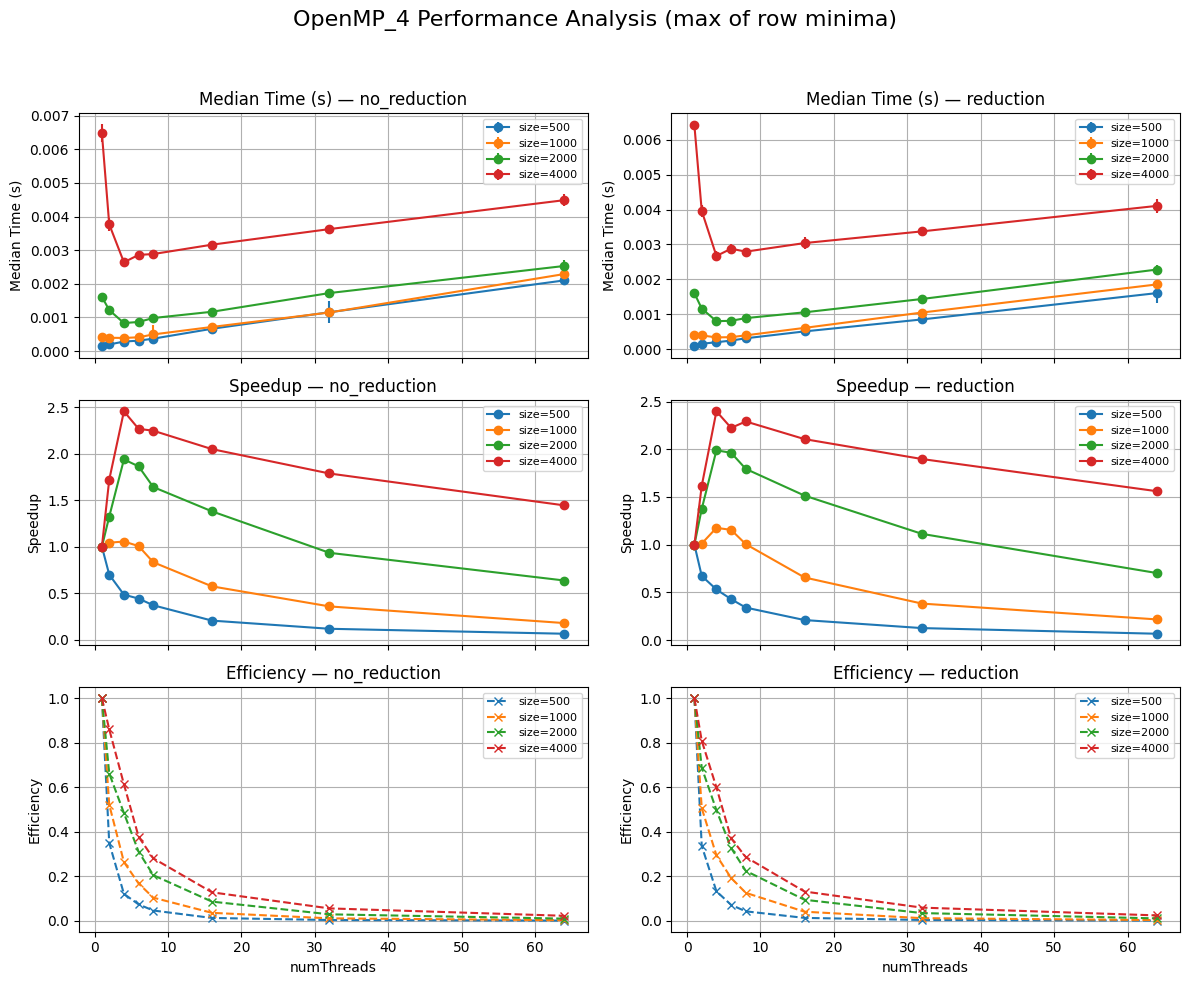

In [12]:
modes = sorted(perfFrame["mode"].unique())
metrics = ["median", "speedup", "efficiency"]
metricLabels = {
    "median": "Median Time (s)",
    "speedup": "Speedup",
    "efficiency": "Efficiency"
}
fig, axes = plt.subplots(3, 2, figsize=(12, 10), sharex=True)
axes = axes.flatten()
for colIdx, modeVal in enumerate(modes):
    for rowIdx, metric in enumerate(metrics):
        axIdx = rowIdx*2 + colIdx
        ax = axes[axIdx]
        for matrixSizeVal in sorted(perfFrame["matrixSize"].unique()):
            subFrame = perfFrame[(perfFrame["mode"]==modeVal) & (perfFrame["matrixSize"]==matrixSizeVal)].sort_values("numThreads")
            if subFrame.empty:
                continue
            x = subFrame["numThreads"].values
            y = subFrame[metric].values
            if metric == "median":
                yerr = subFrame["std"].values
                ax.errorbar(x, y, yerr=yerr, marker='o', linestyle='-', label=f"size={matrixSizeVal}")
            else:
                markerStyle = 'o' if metric == "speedup" else 'x'
                linestyle = '-' if metric == "speedup" else '--'
                ax.plot(x, y, marker=markerStyle, linestyle=linestyle, label=f"size={matrixSizeVal}")
        ax.set_title(f"{metricLabels[metric]} — {modeVal}")
        if rowIdx == 2:
            ax.set_xlabel("numThreads")
        ax.set_ylabel(metricLabels[metric])
        ax.grid(True)
        ax.legend(fontsize=8)
plt.suptitle("OpenMP_4 Performance Analysis (max of row minima)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [13]:
for modeVal in perfFrame["mode"].unique():
    pivotTime = perfFrame[perfFrame["mode"]==modeVal].pivot(index="numThreads", columns="matrixSize", values="median")
    pivotSpeedup = perfFrame[perfFrame["mode"]==modeVal].pivot(index="numThreads", columns="matrixSize", values="speedup")
    print(f"\n=== mode: {modeVal} — median time (s) ===")
    display(pivotTime)
    print(f"\n=== mode: {modeVal} — speedup ===")
    display(pivotSpeedup)


=== mode: no_reduction — median time (s) ===


matrixSize,500,1000,2000,4000
numThreads,,,,
1,0.000136,0.000411,0.001611,0.006480
2,0.000195,0.000394,0.001218,0.003768
4,0.000282,0.000389,0.000832,0.002641
6,0.000308,0.000409,0.000865,0.002861
8,0.000368,0.000494,0.000982,0.002886
16,0.000663,0.000717,0.001168,0.003165
32,0.001154,0.001147,0.001725,0.003628
64,0.002102,0.002291,0.002531,0.004489



=== mode: no_reduction — speedup ===


matrixSize,500,1000,2000,4000
numThreads,,,,
1,1.000000,1.000000,1.000000,1.000000
2,0.699129,1.042607,1.323314,1.720034
4,0.484547,1.055456,1.937012,2.453860
6,0.442570,1.006365,1.862675,2.265478
8,0.370451,0.832523,1.640269,2.245539
16,0.205825,0.573681,1.379269,2.047714
32,0.118146,0.358382,0.933982,1.786021
64,0.064884,0.179410,0.636615,1.443553



=== mode: reduction — median time (s) ===


matrixSize,500,1000,2000,4000
numThreads,,,,
1,0.000108,0.000404,0.001605,0.006405
2,0.000161,0.000399,0.001167,0.003960
4,0.000204,0.000343,0.000807,0.002671
6,0.000252,0.000349,0.000818,0.002880
8,0.000317,0.000402,0.000895,0.002796
16,0.000514,0.000615,0.001060,0.003041
32,0.000857,0.001054,0.001442,0.003375
64,0.001610,0.001858,0.002283,0.004104



=== mode: reduction — speedup ===


matrixSize,500,1000,2000,4000
numThreads,,,,
1,1.000000,1.000000,1.000000,1.000000
2,0.672671,1.012030,1.375107,1.617327
4,0.530882,1.176573,1.988973,2.397567
6,0.429762,1.155695,1.963189,2.224070
8,0.341210,1.005729,1.794233,2.291136
16,0.210659,0.656906,1.514577,2.106317
32,0.126430,0.383221,1.113632,1.897639
64,0.067271,0.217342,0.703092,1.560507


In [14]:
summaryRows = []
for (modeVal, matrixSizeVal), sub in perfFrame.groupby(["mode","matrixSize"]):
    maxSpeedup = sub["speedup"].max()
    argMax = sub.loc[sub["speedup"].idxmax()]
    bestThreads = int(argMax["numThreads"])
    effAtBest = float(argMax["efficiency"])
    medianAtOne = sub.loc[sub["numThreads"]==1, "median"]
    medianAtOne = float(medianAtOne.values[0]) if not medianAtOne.empty else np.nan
    summaryRows.append({
        "mode": modeVal,
        "matrixSize": matrixSizeVal,
        "bestNumThreads": bestThreads,
        "maxSpeedup": maxSpeedup,
        "efficiencyAtBest": effAtBest,
        "medianTime1Thread": medianAtOne
    })
summaryAnalysisFrame = pd.DataFrame(summaryRows).sort_values(["mode","matrixSize"])
display(summaryAnalysisFrame)


,mode,matrixSize,bestNumThreads,maxSpeedup,efficiencyAtBest,medianTime1Thread
0,no_reduction,500,1,1.000000,1.000000,0.000136
1,no_reduction,1000,4,1.055456,0.263864,0.000411
2,no_reduction,2000,4,1.937012,0.484253,0.001611
3,no_reduction,4000,4,2.453860,0.613465,0.006480
4,reduction,500,1,1.000000,1.000000,0.000108
5,reduction,1000,4,1.176573,0.294143,0.000404
6,reduction,2000,4,1.988973,0.497243,0.001605
7,reduction,4000,4,2.397567,0.599392,0.006405
